In [5]:
import numpy as np
from scipy import ndimage
import matplotlib.patches as patches
import matplotlib.pyplot as plt

In [6]:
%load_ext kedro.extras.extensions.ipython
%reload_kedro

[09/29/22 21:53:54] INFO     Updated path to Kedro project: /Users/jordan/Library/Mobile              ]8;id=732428;file:///Users/jordan/mambaforge/envs/sunspots/lib/python3.10/site-packages/kedro/extras/extensions/ipython.py\ipython.py]8;;\:]8;id=479580;file:///Users/jordan/mambaforge/envs/sunspots/lib/python3.10/site-packages/kedro/extras/extensions/ipython.py#53\53]8;;\
                             Documents/com~apple~CloudDocs/Code/University/Revisions/sunspots                      

2022-09-29 21:53:59,670 - kedro.extras.extensions.ipython - INFO - Kedro project Sunspots
2022-09-29 21:53:59,674 - kedro.extras.extensions.ipython - INFO - Defined global variable 'context', 'session', 'catalog' and 'pipelines'
2022-09-29 21:54:01,515 - kedro.extras.extensions.ipython - INFO - Registered line magic 'run_viz'
2022-09-29 21:54:01,517 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/jordan/Library/Mobile Documents/com~apple~CloudDocs/Code/University/Revisions/sunspots
2022-09-29 21:54:02,219 - kedro.extras.extensions.ipython - INFO - Kedro project Sunspots
2022-09-29 21:54:02,221 - kedro.extras.extensions.ipython - INFO - Defined global variable 'context', 'session', 'catalog' and 'pipelines'
2022-09-29 21:54:02,254 - kedro.extras.extensions.ipython - INFO - Registered line magic 'run_viz'


In [7]:
%matplotlib widget

In [8]:
data = catalog.load("training_dataset")
len(data)


2022-09-29 21:54:05,404 - kedro.io.data_catalog - INFO - Loading data from 'training_dataset' (PartitionedDataSet)...


60

In [9]:
targets = catalog.load("training_targets")


2022-09-29 21:54:09,074 - kedro.io.data_catalog - INFO - Loading data from 'training_targets' (PickleDataSet)...


In [10]:
box_size = catalog.load("params:box_size")
num_files = len(targets)
num_files


2022-09-29 21:54:12,543 - kedro.io.data_catalog - INFO - Loading data from 'params:box_size' (MemoryDataSet)...


60

In [11]:
def overplot_spots_from_mask(ax, mask, boxSize):
    """
    Plot the mask onto a given set of axes, drawing the selected regions in
    red.

    Parameters
    ----------
    ax : Matplotlib axes
        The axes to which to add the boxes from the mask.
    mask : np.ndarray
        The mask indicating the regions to draw.
    boxSize : int
        The size each block in the mask represents on the image.
    """
    boxCoords = zip(*np.unravel_index(mask.reshape(-1).nonzero()[0], mask.shape))
    for c in boxCoords:
        boxX = boxSize
        boxY = boxSize
        boxAnchor = (c[1] * boxX - 0.5, c[0] * boxY - 0.5)
        newRect = patches.Rectangle(
            boxAnchor, boxX, boxY, linewidth=1, edgecolor="r", facecolor="none"
        )
        ax.add_patch(newRect)


In [12]:
smap = data["hmi_ic_45s_2011_01_01_00_01_30_tai_continuum"]()


In [13]:
list(data.items())[0]


(
    'hmi_ic_45s_2011_01_01_00_01_30_tai_continuum',
    <bound method AbstractVersionedDataSet.load of <sunspots.extras.datasets.sunpy_datasets.SunPyMapDataSet object at 0x107075ae0>>
)

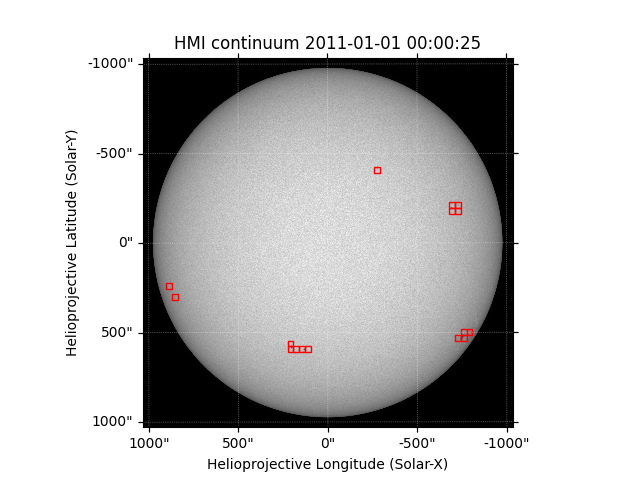

In [14]:
fig, axes = plt.subplots(subplot_kw={"projection": smap})
smap.plot()
overplot_spots_from_mask(axes, targets[0], box_size)


In [15]:
def _select_region(labels, index, box_size, contour_size=None):
    """
    Return the bottom left and top right corners of the
    bounding box of a labelled image region, optionally
    contouring around the box to "fuzzily" include
    features on the edge.

    Parameters
    ----------
    labels : np.ndarray
        The integer labelled mask (produced by e.g. scipy.ndimage.label).
    index : int
        The labelled region to extract.
    box_size : int
        The size of the boxes used to define the regions.
    contour_size : Optional[int]
        The size to add onto each side of the region when defining
        the bounding box. Defauly: boxSize // 2.

    Returns
    -------
    bottomLeft, topRight : Tuple[int, int]
        The pixel coordinates of the corners of the selected region.
    """
    if contour_size is None:
        contour_size = box_size // 2

    coords = np.argwhere(labels == index)
    min_x = np.min(coords[:, 1])
    max_x = np.max(coords[:, 1])
    min_y = np.min(coords[:, 0])
    max_y = np.max(coords[:, 0])

    bottom_left = (
        (max_x + 1) * box_size + contour_size // 2,
        (max_y + 1) * box_size + contour_size // 2,
    )
    top_right = (
        min_x * box_size - contour_size // 2,
        min_y * box_size - contour_size // 2,
    )
    return bottom_left, top_right

In [18]:
from typing import Callable


def get_regions(dataset:dict[str,Callable], targets:np.ndarray):
    regions = {}
    for key, mask in zip(dataset.keys(), targets):
        regions[key] = []
        labeled_array, num_features = ndimage.label(mask)
        for index in range(1, num_features + 1):
            bounding_coords = _select_region(labeled_array, index, box_size)
            regions[key].append(bounding_coords)
    return regions


In [2]:
def extract_region(smap, bottomLeft, topRight):
    """
    Extract a submap from the provided pixel coordinates
    (obtained from select_region).

    Parameters
    ----------
    smap : sunpy.map.Map
        The HMI map.
    bottomLeft : Tuple[int, int]
        The bottom left pixel coordinate pair.
    topRight : Tuple[int, int]
        The top right pixel coordinate pair.

    Returns
    -------
    submap : sunpy.map.Map
        The submap of the selected region.
    """
    bl = smap.wcs.pixel_to_world(*bottomLeft)
    tr = smap.wcs.pixel_to_world(*topRight)
    return smap.submap(bottom_left=bl, top_right=tr)

In [3]:
test = (1,2) 
left, right = test
print(left)
print(right)


1
2


In [ ]:
def extract_regions(dataset, region_coords):
    extractions = {}
    for key, smap, coords in zip(dataset.items(), region_coords.values()):
        extractions[key] = []
        for coord in coords:
            bottom_left, top_right = coord:
            region_map = extract_region(smap, bottom_left, top_right)
            extractions[key].append(region_map)

In [ ]:
def extract(files, Class_regions):
    extractions = {}
    print("Extracting regions...")
    for file, idx in tqdm(zip(files, Class_regions)):
        extractions[idx] = []
        # smap = Map(file)
        regions = Class_regions[idx]
        for corner in regions:
            extractions[idx].append(extract_region(smap, corner[0], corner[1]))
    print("Complete.\n")
    return extractions

In [19]:
get_regions(data, targets)

{
    'hmi_ic_45s_2011_01_01_00_01_30_tai_continuum': [
        ((1872, 976), (1584, 816)),
        ((3664, 1104), (3440, 944)),
        ((400, 1488), (304, 1392)),
        ((336, 1616), (240, 1520)),
        ((3536, 2512), (3376, 2352)),
        ((2640, 2896), (2544, 2800))
    ],
    'hmi_ic_45s_2011_01_29_00_01_30_tai_continuum': [
        ((528, 1616), (432, 1520)),
        ((464, 1680), (368, 1584)),
        ((3728, 2768), (3568, 2544))
    ],
    'hmi_ic_45s_2011_02_12_00_01_30_tai_continuum': [
        ((2064, 1232), (1904, 1136)),
        ((2960, 1296), (2864, 1136)),
        ((3920, 1616), (3824, 1456)),
        ((1808, 2576), (1712, 2416)),
        ((2064, 2512), (1968, 2416)),
        ((2960, 2576), (2672, 2416)),
        ((3024, 2640), (2928, 2544))
    ],
    'hmi_ic_45s_2011_02_19_00_01_30_tai_continuum': [
        ((2064, 1296), (1712, 1072)),
        ((2192, 1488), (1776, 1328)),
        ((592, 2704), (304, 2480))
    ],
    'hmi_ic_45s_2011_03_05_00_01_30_tai_continuum': [
        ((1872, 912), (1776, 816)),
        ((1744, 1168), (1264, 880)),
        ((464, 1232), (368, 1072)),
        ((2640, 1424), (2544, 1328)),
        ((2832, 1424), (2672, 1328)),
        ((3728, 1744), (3440, 1520)),
        ((912, 2512), (752, 2352)),
        ((1104, 2640), (1008, 2544))
    ],
    'hmi_ic_45s_2011_03_26_00_01_30_tai_continuum': [
        ((2896, 1232), (2736, 1136)),
        ((3664, 1232), (3568, 1136)),
        ((2960, 1296), (2864, 1200)),
        ((720, 1616), (624, 1520)),
        ((3152, 2576), (2736, 2160)),
        ((3664, 2512), (3504, 2352)),
        ((3728, 2960), (3632, 2736))
    ],
    'hmi_ic_45s_2011_04_02_00_01_30_tai_continuum': [
        ((1424, 1104), (1264, 1008)),
        ((720, 1168), (624, 1072)),
        ((2064, 1424), (1840, 1200)),
        ((2320, 1360), (2160, 1200)),
        ((400, 1360), (304, 1264)),
        ((3024, 1424), (2928, 1328)),
        ((336, 2512), (240, 2416)),
        ((528, 2512), (432, 2416)),
        ((1936, 2704), (1840, 2608))
    ],
    'hmi_ic_45s_2011_04_30_00_01_30_tai_continuum': [
        ((592, 1424), (368, 1200)),
        ((3792, 1488), (3568, 1328)),
        ((720, 1488), (560, 1392)),
        ((2512, 1488), (2416, 1392)),
        ((2448, 1552), (2352, 1456)),
        ((400, 2576), (304, 2416)),
        ((2320, 2576), (2160, 2416)),
        ((528, 2576), (432, 2480))
    ],
    'hmi_ic_45s_2011_05_14_00_01_30_tai_continuum': [
        ((784, 1424), (688, 1328)),
        ((1616, 1552), (1520, 1456)),
        ((1296, 1744), (1200, 1584)),
        ((464, 2704), (304, 2608)),
        ((1552, 2704), (1456, 2608)),
        ((2896, 2832), (2672, 2672))
    ],
    'hmi_ic_45s_2011_06_25_00_01_30_tai_continuum': [
        ((2832, 1360), (2736, 1264)),
        ((528, 1616), (368, 1392)),
        ((2000, 1552), (1776, 1392)),
        ((848, 1616), (752, 1520)),
        ((1680, 2768), (1584, 2672)),
        ((3728, 2896), (3632, 2800))
    ],
    'hmi_ic_45s_2011_07_02_00_01_30_tai_continuum': [
        ((912, 1616), (752, 1456)),
        ((1872, 1680), (1776, 1520)),
        ((2896, 1680), (2608, 1520)),
        ((784, 1680), (688, 1584)),
        ((1680, 1744), (1584, 1648))
    ],
    'hmi_ic_45s_2011_07_16_00_01_30_tai_continuum': [
        ((3344, 1424), (3248, 1328)),
        ((720, 1680), (624, 1584)),
        ((2704, 1744), (2544, 1584)),
        ((3088, 1936), (2992, 1840)),
        ((3216, 1936), (3120, 1840)),
        ((3472, 2960), (3248, 2800)),
        ((1552, 3088), (1328, 2928))
    ],
    'hmi_ic_45s_2011_07_23_00_01_30_tai_continuum': [
        ((2640, 1488), (2416, 1328)),
        ((400, 1616), (240, 1520)),
        ((976, 2896), (880, 2800)),
        ((912, 2960), (816, 2864)),
        ((1104, 2960), (944, 2864))
    ],
    'hmi_ic_45s_2011_08_13_00_01_30_tai_continuum': [
        ((528, 1488), (432, 1392)),
        ((3216, 1488), (3120, 1392)),
        ((3344, 1488), (3248, 1392)),
        ((2192, 2960), (2096, 2864))
    ],
    'hmi_ic_45s_2011_08_20_

In [24]:
regions

[
    [
        ((1872, 976), (1584, 816)),
        ((3664, 1104), (3440, 944)),
        ((400, 1488), (304, 1392)),
        ((336, 1616), (240, 1520)),
        ((3536, 2512), (3376, 2352)),
        ((2640, 2896), (2544, 2800))
    ],
    [((528, 1616), (432, 1520)), ((464, 1680), (368, 1584)), ((3728, 2768), (3568, 2544))],
    [
        ((2064, 1232), (1904, 1136)),
        ((2960, 1296), (2864, 1136)),
        ((3920, 1616), (3824, 1456)),
        ((1808, 2576), (1712, 2416)),
        ((2064, 2512), (1968, 2416)),
        ((2960, 2576), (2672, 2416)),
        ((3024, 2640), (2928, 2544))
    ],
    [((2064, 1296), (1712, 1072)), ((2192, 1488), (1776, 1328)), ((592, 2704), (304, 2480))],
    [
        ((1872, 912), (1776, 816)),
        ((1744, 1168), (1264, 880)),
        ((464, 1232), (368, 1072)),
        ((2640, 1424), (2544, 1328)),
        ((2832, 1424), (2672, 1328)),
        ((3728, 1744), (3440, 1520)),
        ((912, 2512), (752, 2352)),
        ((1104, 2640), (1008, 2544))
    ],
    [
        ((2896, 1232), (2736, 1136)),
        ((3664, 1232), (3568, 1136)),
        ((2960, 1296), (2864, 1200)),
        ((720, 1616), (624, 1520)),
        ((3152, 2576), (2736, 2160)),
        ((3664, 2512), (3504, 2352)),
        ((3728, 2960), (3632, 2736))
    ],
    [
        ((1424, 1104), (1264, 1008)),
        ((720, 1168), (624, 1072)),
        ((2064, 1424), (1840, 1200)),
        ((2320, 1360), (2160, 1200)),
        ((400, 1360), (304, 1264)),
        ((3024, 1424), (2928, 1328)),
        ((336, 2512), (240, 2416)),
        ((528, 2512), (432, 2416)),
        ((1936, 2704), (1840, 2608))
    ],
    [
        ((592, 1424), (368, 1200)),
        ((3792, 1488), (3568, 1328)),
        ((720, 1488), (560, 1392)),
        ((2512, 1488), (2416, 1392)),
        ((2448, 1552), (2352, 1456)),
        ((400, 2576), (304, 2416)),
        ((2320, 2576), (2160, 2416)),
        ((528, 2576), (432, 2480))
    ],
    [
        ((784, 1424), (688, 1328)),
        ((1616, 1552), (1520, 1456)),
        ((1296, 1744), (1200, 1584)),
        ((464, 2704), (304, 2608)),
        ((1552, 2704), (1456, 2608)),
        ((2896, 2832), (2672, 2672))
    ],
    [
        ((2832, 1360), (2736, 1264)),
        ((528, 1616), (368, 1392)),
        ((2000, 1552), (1776, 1392)),
        ((848, 1616), (752, 1520)),
        ((1680, 2768), (1584, 2672)),
        ((3728, 2896), (3632, 2800))
    ],
    [
        ((912, 1616), (752, 1456)),
        ((1872, 1680), (1776, 1520)),
        ((2896, 1680), (2608, 1520)),
        ((784, 1680), (688, 1584)),
        ((1680, 1744), (1584, 1648))
    ],
    [
        ((3344, 1424), (3248, 1328)),
        ((720, 1680), (624, 1584)),
        ((2704, 1744), (2544, 1584)),
        ((3088, 1936), (2992, 1840)),
        ((3216, 1936), (3120, 1840)),
        ((3472, 2960), (3248, 2800)),
        ((1552, 3088), (1328, 2928))
    ],
    [
        ((2640, 1488), (2416, 1328)),
        ((400, 1616), (240, 1520)),
        ((976, 2896), (880, 2800)),
        ((912, 2960), (816, 2864)),
        ((1104, 2960), (944, 2864))
    ],
    [
        ((528, 1488), (432, 1392)),
        ((3216, 1488), (3120, 1392)),
        ((3344, 1488), (3248, 1392)),
        ((2192, 2960), (2096, 2864))
    ],
    [
        ((2960, 1680), (2864, 1520)),
        ((2832, 1872), (2608, 1584)),
        ((2960, 1872), (2800, 1712)),
        ((1232, 2896), (1136, 2800)),
        ((2960, 2960), (2800, 2864)),
        ((3024, 3024), (2928, 2928)),
        ((3088, 3088), (2992, 2992))
    ],
    [
        ((784, 1488), (688, 1328)),
        ((336, 1488), (240, 1392)),
        ((3280, 1616), (3184, 1520)),
        ((1168, 1936), (880, 1584)),
        ((3600, 1744), (3504, 1584)),
        ((272, 1744), (176, 1648)),
        ((1424, 1872), (1264, 1648)),
        ((2768, 1872), (2672, 1712)),
        ((3408, 1808), (3312, 1712)),
        ((2192, 2000), (1968, 1776)),
        ((3728, 2960), (3632, 2864)),
        ((2576, 3088), (2480, 2928)),
        ((3152, 3088), (30

In [ ]:
def get_regions(self):
    self.regions = {}
    for index, prediction in enumerate(self.predictions):
        self.regions[index] = []
        labeled_array, num_features = ndimage.label(prediction)
        for idx in range(1, num_features + 1):
            self.regions[index].append(
                select_region(labeled_array, idx, boxSize=self.boxsize)
            )
